In [19]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [ ]:
stan_code = """

data {
    int<lower=1> training_size;
    //real tau_0;
    //real tau_1;
    //real sigma_a;
    //real sigma_b;
    matrix[training_size, 3] x;
    vector[training_size] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

// transformed parameters {
//   matrix[N, N] I = diag(rep_vector(1, N));
// }

model {
    sigma ~ inv_gamma(.1, .3);
    alpha ~ normal(0, 1);
    beta ~ normal(0,1);

    // sigma ~ inv_gamma(tau_0, tau_1);
    // alpha ~ normal(0, sigma_a);
    // beta ~ multi_normal(0,sigma_b * I);

    // y ~ multi_normal(x * beta, sigma);

    for (n in 1:training_size) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

generated quantities{
  array[training_size] real pred_distr;
  for(i in 1:training_size){
    pred_distr[i] = normal_rng(alpha + beta' * (x[i]'), sigma);
  }
}

"""

In [30]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())

# Also standardize the charges
insurance_data["charges"] = (insurance_data['charges'] - insurance_data['charges'].mean())/(insurance_data['charges'].std())

parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]

split_proportion = 0.9
split_row = int(num_rows * split_proportion)

training_data_params = parameter_vals[:split_row, :]
testing_data_params = parameter_vals[split_row:, :]

training_data_charges = charges_vals[:split_row]
testing_data_charges = charges_vals[split_row:]

print(training_data_charges.shape)
print(testing_data_charges.shape)
print(charges_vals.shape)

(1204,)
(134,)
(1338,)


In [31]:

data_dict = {
    'training_size': training_data_charges.shape[0],
    # 'tau_0': 0.3,
    # 'tau_1': 0.6,
    # 'sigma_a': 5,
    # 'sigma_b': 1,
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': training_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: 60.9s, done.

In [32]:
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=100)

Sampling:   0%
Sampling:   0% (1/4400)
Sampling:   0% (2/4400)
Sampling:  25% (1102/4400)
Sampling:  50% (2202/4400)
Sampling:  75% (3301/4400)
Sampling: 100% (4400/4400)
Sampling: 100% (4400/4400), done.
Messages received during sampling:
  Gradient evaluation took 0.003456 seconds
  1000 transitions using 10 leapfrog steps per transition would take 34.56 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 15
             adapt_window = 75
             term_buffer = 10
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_dwu4egxa/model_uyvqfxum.stan', line 35, column 8 to column 54)
  If this warning occurs sporadically, such as for highly const

In [33]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.941,0.019,0.905,0.977,0.000,0.000,6326.0,3024.0,1.0
alpha,-0.003,0.027,-0.052,0.051,0.000,0.000,4400.0,2824.0,1.0
beta[0],0.279,0.027,0.230,0.332,0.000,0.000,4194.0,2635.0,1.0
beta[1],0.164,0.027,0.115,0.217,0.000,0.000,4215.0,3083.0,1.0
beta[2],0.055,0.027,0.004,0.105,0.000,0.000,4349.0,3314.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_distr[1199],0.118,0.934,-1.716,1.779,0.015,0.010,3986.0,3931.0,1.0
pred_distr[1200],-0.318,0.914,-2.072,1.363,0.015,0.010,3921.0,3477.0,1.0
pred_distr[1201],-0.270,0.945,-1.945,1.562,0.015,0.011,4020.0,3756.0,1.0
pred_distr[1202],0.577,0.932,-1.205,2.241,0.015,0.010,3892.0,3954.0,1.0


/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1209), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'pred_distr\n0'}>,
        <Axes: title={'center': 'pred_distr\n0'}>],
       [<Axes: title={'center': 'pred_distr\n1'}>,
        <Axes: title={'center': 'pred_distr\n1'}>],
       [<Axes: title={'center': 'pred_distr\n2'}>,
        <Axes: title={'center': 'pred_distr\n2'}>],
       [<Axes: title={'center': 'pred_distr\n3'}>,
        <Axes: title={'center': 'pred_distr\n3'}>],
       [<Axes: title={'center': 'pred_distr\n4'}>,
        <Axes: title={'center': 'pred_distr\n4'}>],
       [<Axes: title={'center': 'pred_

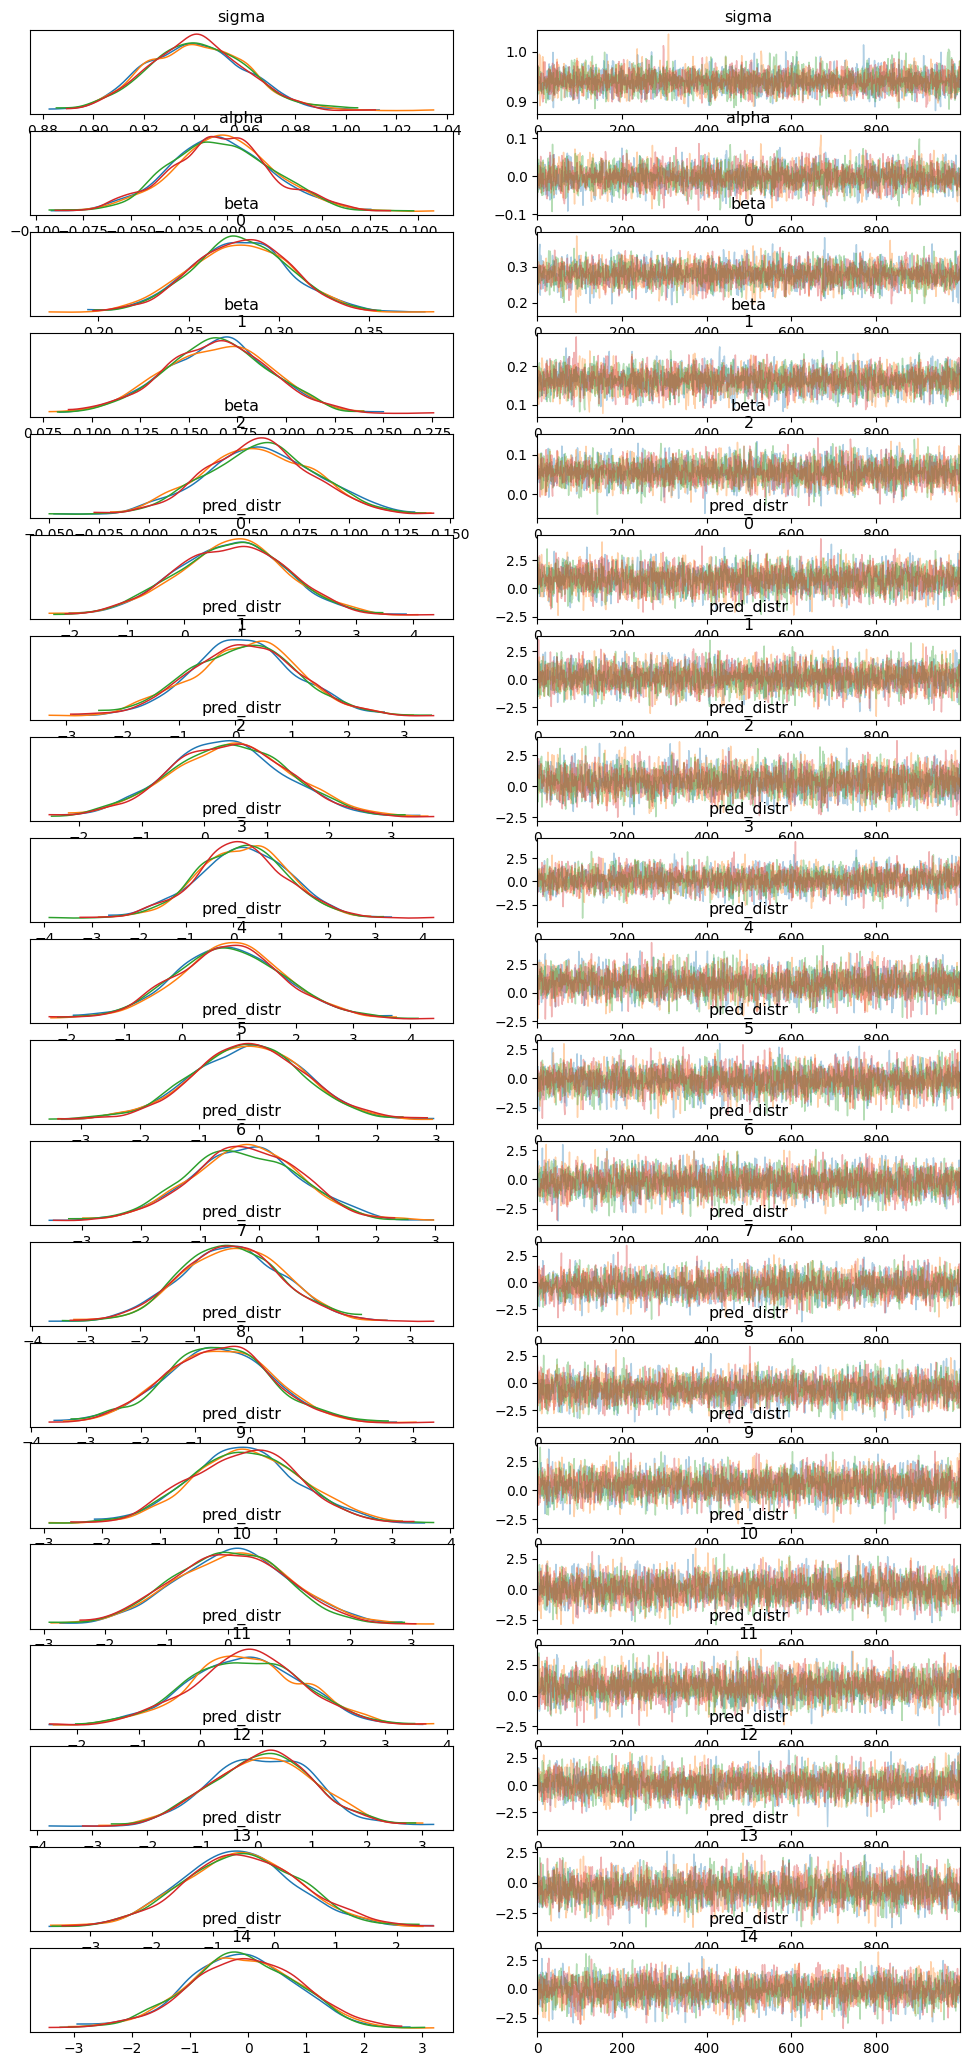

In [34]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

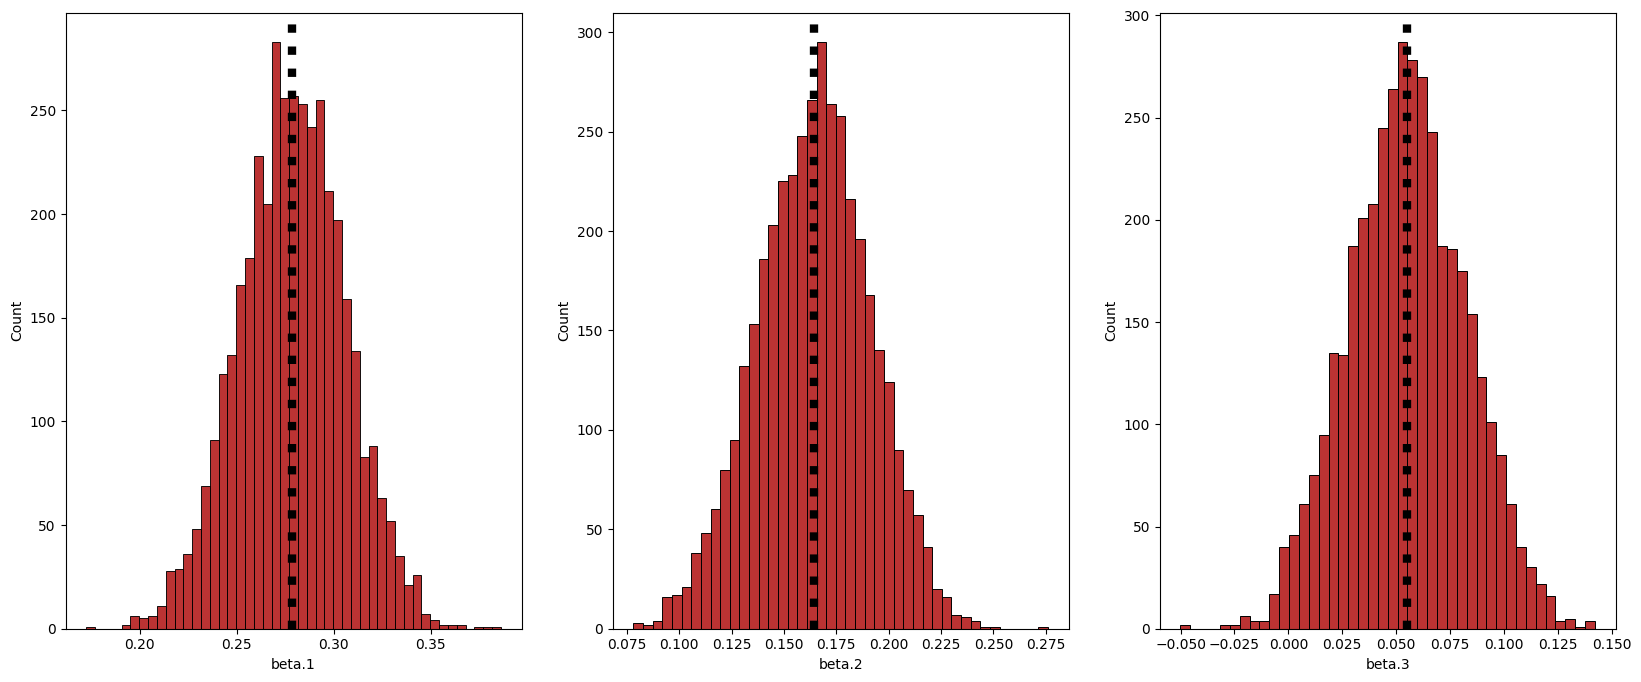

In [35]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [36]:
pred_distr = fit['pred_distr'] #Predictive distribution
num_samples = testing_data_charges.shape[0] #Nunmber of samples
pred_means = np.mean(pred_distr, axis=1) #Predictive distribution means
pred_samples = np.random.choice(pred_means, size=num_samples)

In [37]:
print (pred_samples.shape)
print (testing_data_charges.shape)

#Calculate the RMSE
rmse = np.sqrt((1/num_samples) * np.sum((pred_samples - testing_data_charges)**2))
print(f"RMSE = {rmse}")

(134,)
(134,)
RMSE = 1.1175089026250367
